In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from tpot.export_utils import set_param_recursive
import xarray as xr
from SALib.sample import saltelli
from SALib.analyze import sobol
import joblib
import re
import os
import dask
import dask.bag as db

/nfs/b0122/Users/earlacoa/miniconda3/envs/python3/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)
import geoplot.crs as gcrs
import geoplot

In [3]:
import sys
sys.path.append('/nfs/see-fs-02_users/earlacoa/wrf-analysis/misc/')
from cutshapefile import transform_from_latlon, rasterize
from import_npz import import_npz
import geopandas as gpd
import joblib

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(
    dashboard_address=':5757',
)
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://127.0.0.1:35411 Dashboard: http://127.0.0.1:5757/status,Cluster Workers: 8 Cores: 32 Memory: 405.66 GB


In [ ]:
client.close()
cluster.close()

#### plots

In [86]:
# regions
gdf_china_north = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north.shp')
gdf_china_north_east = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north_east.shp')
gdf_china_east = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_east.shp')
gdf_china_south_central = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_south_central.shp')
gdf_china_south_west = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_south_west.shp')
gdf_china_north_west = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north_west.shp')

gdf_gba = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gba.shp')

In [87]:
gdf_regions = pd.concat([
    gdf_china_north,
    gdf_china_north_east,
    gdf_china_east,
    gdf_china_south_central,
    gdf_china_south_west,
    gdf_china_north_west
]).pipe(gpd.GeoDataFrame)
gdf_regions['regions'] = [1,2,3,4,5,6]

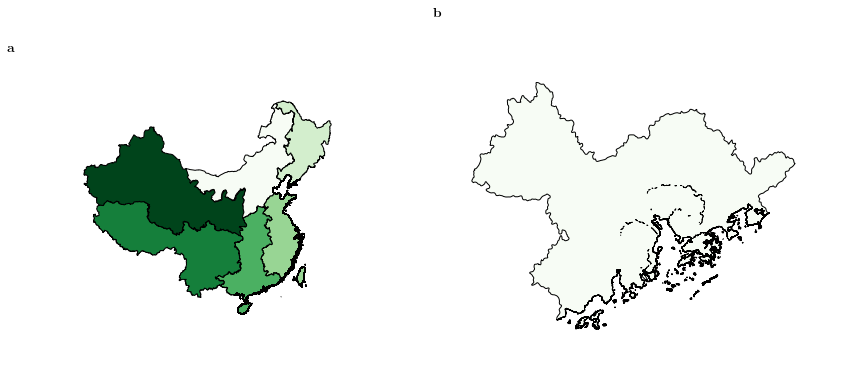

In [107]:
proj = gcrs.AlbersEqualArea(central_latitude=35, central_longitude=105)
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121, projection=proj)
ax2 = plt.subplot(122, projection=proj)

ax1.annotate(r'\textbf{a}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
geoplot.choropleth(gdf_regions, projection=proj, hue='regions', cmap='Greens', ax=ax1, edgecolor='Black')

ax2.annotate(r'\textbf{b}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
geoplot.choropleth(gdf_gba, projection=proj, hue='id', cmap='Greens', ax=ax2, edgecolor='Black')

plt.tight_layout()
plt.savefig('/nfs/b0122/earlacoa/png/paper_aia_emulator/regions.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig('/nfs/b0122/earlacoa/png/paper_aia_emulator/regions.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

#### scatter

In [ ]:
def make_plot(index, output, df_eval_summary, label, y_test, y_pred):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    limit = np.nanmax(y_pred)
    plt.xlim([0, limit])
    plt.ylim([0, limit])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Simulator, ' + label, fontsize=14)
    plt.ylabel('Emulator, ' + label, fontsize=14)
    plt.scatter(np.vstack(y_test), np.vstack(y_pred))
    x = np.arange(2 * np.ceil(limit))
    plt.plot(x, x, '', color='grey', ls='--')
    plt.plot(x, 0.5 * x, '', color='grey', ls='--')
    plt.plot(x, 2 * x, '', color='grey', ls='--')
    text_cv = "R$^2$ CV = " + str(np.round(np.nanmean(df_eval_summary['r2_cv'].values[0]), decimals=3)) + \
           "\nRMSE CV = " + str(np.round(np.nanmean(df_eval_summary['rmse_cv'].values[0]), decimals=3))
    text_test = "R$^2$ test = " + str(np.round(np.nanmean(df_eval_summary['r2_test'].values[0]), decimals=3)) + \
           "\nRMSE test = " + str(np.round(np.nanmean(df_eval_summary['rmse_test'].values[0]), decimals=3))
    at_cv = matplotlib.offsetbox.AnchoredText(text_cv, prop=dict(size=14), frameon=True, loc='upper left')
    at_cv.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at_cv)
    at_test = matplotlib.offsetbox.AnchoredText(text_test, prop=dict(size=14), frameon=True, loc='lower right')
    at_test.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
    ax.add_artist(at_test)

In [ ]:
fig = plt.figure(1, figsize=(15, 20))
gs = gridspec.GridSpec(4, 3)

path = '/nfs/b0004/Users/earlacoa/paper_aia_china/emulator/'

outputs = ['PM2_5_DRY', 'o3', 'AOD550_sfc', 'asoaX_2p5', 'bc_2p5', 'bsoaX_2p5', 'nh4_2p5', 'no3_2p5', 'oc_2p5', 'oin_2p5', 'so4_2p5']
labels = ['ambient PM$_{2.5}$ concentrations\n(${\mu}g$ $m^{-3}$)',
          'ambient O$_{3}$ concentrations\n($ppbv$)',
          'surface AOD 550 nm',
          'anthropogenic SOA concentrations\n(${\mu}g$ $m^{-3}$)',
          'BC concentrations\n(${\mu}g$ $m^{-3}$)',
          'biogenic SOA concentrations\n(${\mu}g$ $m^{-3}$)',
          'NH$_{4}$ concentrations\n(${\mu}g$ $m^{-3}$)',
          'NO$_{3}$ concentrations\n(${\mu}g$ $m^{-3}$)',
          'OC concentrations\n(${\mu}g$ $m^{-3}$)',
          'OIN concentrations\n(${\mu}g$ $m^{-3}$)',
          'SO$_{4}$ concentrations\n(${\mu}g$ $m^{-3}$)']
pattern = r'([+-]?\d+.?\d+)'

for index, output in enumerate(outputs):
    y_values = np.load(path + output + '/y_test_pred_' + output + '.npz')
    y_test = y_values['y_test']
    y_pred = y_values['y_pred']
    df_eval_summary = pd.read_csv(path + output + '/df_eval_summary_' + output + '.csv')   
    make_plot(index, output, df_eval_summary, labels[index], y_test, y_pred)

gs.tight_layout(fig, rect=[0, 0, 0.85, 0.85])
plt.savefig(path + 'eval.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig(path + 'eval.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

#### sensitivity indices

In [ ]:
#output = 'PM2_5_DRY'
#output = 'o3'
#output = 'AOD550_sfc'
#output = 'asoaX_2p5'
#output = 'bc_2p5'
#output = 'bsoaX_2p5'
#output = 'nh4_2p5'
#output = 'no3_2p5'
#output = 'oc_2p5'
#output = 'oin_2p5'
output = 'so4_2p5'

#label = 'ambient PM$_{2.5}$ concentrations'
#label = 'ambient O$_{3}$ concentrations'
#label = 'surface AOD 550 nm'
#label = 'anthropogenic SOA concentrations'
#label = 'BC concentrations'
#label = 'biogenic SOA concentrations'
#label = 'NH$_{4}$ concentrations'
#label = 'NO$_{3}$ concentrations'
#label = 'OC concentrations'
#label = 'OIN concentrations'
label = 'SO$_{4}$ concentrations'

units = '(${\mu}g$ $m^{-3}$)'
#units = '(ppb)'
#units = ''

In [ ]:
ds_sens_ind = xr.open_dataset(
    path + output + '/ds_sens_ind_' + output + '.nc'
)
lon = ds_sens_ind['S1_RES'].lon.values
lat = ds_sens_ind['S1_RES'].lat.values
xx, yy = np.meshgrid(lon, lat)

conc = xr.open_dataset(
    '/nfs/b0004/Users/earlacoa/paper_aia_china/emulator/summary/ds_ctl_' + output + '.nc'
)[output]

In [ ]:
# first order sensntivity index

fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

sens = 'S1'
region = 'GBA'

sims = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
levels = {}
levels.update({'China':(0,0.075,0.15,0.225,0.30,0.375,0.45,0.525,0.60,0.675,100000)})
levels.update({'GBA':(0,0.075,0.15,0.225,0.30,0.375,0.45,0.525,0.60,0.675,100000)})
cmap_colors = {}
cmap_colors.update({'S1': ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']})
cb_label = {}
cb_label.update({'S1':'First-order sensitivity indices for ' + label})
plots = [(sim, sens, region, levels[region], cmap_colors[sens], cb_label[sens], label) for sim in sims]

for index, item in enumerate(plots):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    if item[2] == 'China':
        ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
        shape_feature = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),
                                       ccrs.PlateCarree(), facecolor='none')
        ax.background_patch.set_visible(False)
        ax.outline_patch.set_visible(False)
        ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
    elif item[2] == 'GBA':
        ax.set_extent([111.3, 115.5, 21.5, 24.5], crs=ccrs.PlateCarree())
        shape_feature1 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_2.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature2 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature3 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature4 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/taiwan/gadm36_TWN_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        ax.add_feature(shape_feature1, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature2, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature3, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature4, edgecolor='black', linewidth=0.5)
    norm = matplotlib.colors.Normalize(vmin=item[3][0], vmax=item[3][-2])
    cmap = matplotlib.colors.ListedColormap(list(item[4]))
    im = ax.contourf(xx, yy, ds_sens_ind[item[1] + '_' + item[0]].values, item[3],
                     cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    #plt.annotate(r'\textbf{' + chr(97 + index) + '}', xy=(0,1.05), xycoords='axes fraction', fontsize=14, weight='bold')
    plt.annotate(chr(97 + index), xy=(0,1.05), xycoords='axes fraction', fontsize=14, weight='bold')
    plt.title(item[0], size=14)

fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 

plt.draw()
    
ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=levels[region][0], vmax=levels[region][-2]),                       
    cmap=im.cmap
)
sm.set_array([])  
cb = plt.colorbar(
    sm, 
    cax=ax_cbar, 
    norm=matplotlib.colors.Normalize(vmin=levels[region][0], vmax=levels[region][-2]),              
    cmap=cmap_colors[sens], 
    ticks=levels[region][0:-1]
)
cb.set_label(cb_label[sens], size=14)
cb.ax.tick_params(labelsize=14)

plt.savefig(path + output + '/' + output + '_' + region + '_compare.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig(path + output + '/' + output + '_' + region + '_compare.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [ ]:
# absolute sensitivity

fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

sens = 'S1'
region = 'GBA'

sims = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
levels = {}
levels.update({'China_PM2_5_DRY':(0,10,20,30,40,50,60,70,80,90,100000)})
levels.update({'GBA_PM2_5_DRY':(0,5,10,15,20,25,30,35,40,45,100000)})
levels.update({'China_o3':(0,5,10,15,20,25,30,35,40,45,100000)})
levels.update({'GBA_o3':(0,2.5,5,7.5,10,12.5,15,17.5,20,22.5,100000)})
levels.update({'China_AOD550_sfc':(0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,100000)})
levels.update({'GBA_AOD550_sfc':(0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,100000)})
levels.update({'China_asoaX_2p5':(0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,100000)})
levels.update({'GBA_asoaX_2p5':(0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,100000)})
levels.update({'China_bc_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
levels.update({'GBA_bc_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
levels.update({'China_bsoaX_2p5':(0,0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,100000)})
levels.update({'GBA_bsoaX_2p5':(0,0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,100000)})
levels.update({'China_nh4_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
levels.update({'GBA_nh4_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
levels.update({'China_no3_2p5':(0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,100000)})
levels.update({'GBA_no3_2p5':(0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,100000)})
levels.update({'China_oc_2p5':(0,1,2,3,4,5,6,7,8,9,100000)})
levels.update({'GBA_oc_2p5':(0,1,2,3,4,5,6,7,8,9,100000)})
levels.update({'China_oin_2p5':(0,1,2,3,4,5,6,7,8,9,100000)})
levels.update({'GBA_oin_2p5':(0,1,2,3,4,5,6,7,8,9,100000)})
levels.update({'China_so4_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
levels.update({'GBA_so4_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
cmap_colors = {}
cmap_colors.update({'S1': ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']})
cb_label = {}
cb_label.update({'S1':'First-order sensitivity indices for ' + label + '\n multiplied by ' + label + ' from\ncontrol ' + units})
plots = [(sim, sens, region, levels[region + '_' + output], cmap_colors[sens], cb_label[sens], label) for sim in sims]

for index, item in enumerate(plots):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    if item[2] == 'China':
        ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
        shape_feature = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),
                                       ccrs.PlateCarree(), facecolor='none')
        ax.background_patch.set_visible(False)
        ax.outline_patch.set_visible(False)
        ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
    elif item[2] == 'GBA':
        ax.set_extent([111.3, 115.5, 21.5, 24.5], crs=ccrs.PlateCarree())
        shape_feature1 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_2.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature2 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature3 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature4 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/taiwan/gadm36_TWN_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        ax.add_feature(shape_feature1, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature2, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature3, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature4, edgecolor='black', linewidth=0.5)
    norm = matplotlib.colors.Normalize(vmin=item[3][0], vmax=item[3][-2])
    cmap = matplotlib.colors.ListedColormap(list(item[4]))
    im = ax.contourf(xx, yy, ds_sens_ind[item[1] + '_' + item[0]].values * conc.values, item[3],
                     cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    #plt.annotate(r'\textbf{' + chr(97 + index) + '}', xy=(0,1.05), xycoords='axes fraction', fontsize=14, weight='bold')
    plt.annotate(chr(97 + index), xy=(0,1.05), xycoords='axes fraction', fontsize=14, weight='bold')
    plt.title(item[0], size=14)

fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 

plt.draw()
    
ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=levels[region + '_' + output][0], vmax=levels[region + '_' + output][-2]),                       
    cmap=im.cmap
)
sm.set_array([])  
cb = plt.colorbar(
    sm, 
    cax=ax_cbar, 
    norm=matplotlib.colors.Normalize(vmin=levels[region + '_' + output][0], vmax=levels[region + '_' + output][-2]),              
    cmap=cmap_colors[sens], 
    ticks=levels[region + '_' + output][0:-1]
)
cb.set_label(cb_label[sens], size=14)
cb.ax.tick_params(labelsize=14)

plt.savefig(path + output + '/' + output + '_' + region + '_compare_abs.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(path + output + '/' + output + '_' + region + '_compare_abs.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

#### predicted output map for input config

In [ ]:
output = 'PM2_5_DRY'

fraction_res = 1.0
fraction_ind = 1.0
fraction_tra = 1.0
fraction_agr = 1.0
fraction_ene = 1.0

custom_inputs = np.array([
    fraction_res,
    fraction_ind,
    fraction_tra,
    fraction_agr,
    fraction_ene
]).reshape(1, -1)

filename = 'RES' + str(np.round(custom_inputs[0][0], decimals=1)) \
            + '_IND' + str(np.round(custom_inputs[0][1], decimals=1)) \
            + '_TRA' + str(np.round(custom_inputs[0][2], decimals=1)) \
            + '_AGR' + str(np.round(custom_inputs[0][3], decimals=1)) \
            + '_ENE' + str(np.round(custom_inputs[0][4], decimals=1))

ds_custom_output = xr.open_dataset(
    '/nfs/b0004/Users/earlacoa/paper_aia_china/emulator/summary/' + output + '/ds_' + filename + '_' + output + '_popgrid.nc'
)[output]

ds_ctl_output = xr.open_dataset(
    '/nfs/b0004/Users/earlacoa/paper_aia_china/emulator/summary/' + output + '/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_' + output + '_popgrid.nc'
)[output]

lat = ds_ctl_output.lat.values
lon = ds_ctl_output.lon.values
xx, yy = np.meshgrid(lon, lat)

##### plot ctl

In [ ]:
outputs = [
    'PM2_5_DRY',
    'o3',
    'AOD550_sfc',
    'asoaX_2p5',
    'bc_2p5',
    'bsoaX_2p5',
    'nh4_2p5',
    'no3_2p5',
    'oc_2p5',
    'oin_2p5',
    'so4_2p5'
]

labels = [
    'Ambient PM$_{2.5}$ concentrations', 
    'Ambient O$_{3}$ concentrations', 
    'Surface AOD 550 nm', 
    'Anthropogenic SOA concentrations', 
    'BC concentrations', 
    'Biogenic SOA concentrations', 
    'NH$_{4}$ concentrations', 
    'NO$_{3}$ concentrations', 
    'OC concentrations', 
    'OIN concentrations', 
    'SO$_{4}$ concentrations'
]

cb_labels = {}

for index, output in enumerate(outputs):
    cb_label = labels[index]
        
    if output == 'o3':
        cb_label = cb_label + ' (ppb)'
    elif output == 'AOD550_sfc':
        cb_label = cb_label
    else:
        cb_label = cb_label + ' (${\mu}g$ $m^{-3}$)'
        
    cb_labels.update({output: cb_label})

In [ ]:
fig = plt.figure(1, figsize=(10, 5))
gs = gridspec.GridSpec(1, 2)

output = 'PM2_5_DRY'
levels = (0,15,30,45,60,75,90,105,120,135,100000)

# China
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
shape_feature = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),                             
    ccrs.PlateCarree(), 
    facecolor='none'
)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
norm = matplotlib.colors.Normalize(
    vmin=levels[0], 
    vmax=levels[-2]
)
cmap_colors = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
cmap = matplotlib.colors.ListedColormap(cmap_colors)
im = ax.contourf(
    xx, 
    yy, 
    ds_ctl_output, 
    levels,
    cmap=cmap, 
    norm=norm, 
    transform=ccrs.PlateCarree()
)
plt.annotate(r'\textbf{a}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)

# GBA
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.set_extent([111.3, 115.5, 21.5, 24.5], crs=ccrs.PlateCarree())
shape_feature1 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_2.shp').geometries(),
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape_feature2 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_0.shp').geometries(),           
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape_feature3 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_0.shp').geometries(),      
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape_feature4 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/taiwan/gadm36_TWN_0.shp').geometries(),              
    ccrs.PlateCarree(), 
    facecolor='none'
)
ax.add_feature(shape_feature1, edgecolor='black', linewidth=0.5)
ax.add_feature(shape_feature2, edgecolor='black', linewidth=0.5)
ax.add_feature(shape_feature3, edgecolor='black', linewidth=0.5)
ax.add_feature(shape_feature4, edgecolor='black', linewidth=0.5)
norm = matplotlib.colors.Normalize(
    vmin=levels[0], 
    vmax=levels[-2]
)
cmap_colors = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
cmap = matplotlib.colors.ListedColormap(cmap_colors)
im = ax.contourf(
    xx, 
    yy, 
    ds_ctl_output, 
    levels,
    cmap=cmap, 
    norm=norm, 
    transform=ccrs.PlateCarree()
)
plt.annotate(r'\textbf{b}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)

# color bar
fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 

plt.draw()
    
ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.65])
sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=levels[0], 
        vmax=levels[-2]
    ),                       
    cmap=im.cmap
)
sm.set_array([])  
cb = plt.colorbar(
    sm, 
    cax=ax_cbar, 
    norm=matplotlib.colors.Normalize(
        vmin=levels[0], 
        vmax=levels[-2]
    ),              
    cmap=cmap, 
    ticks=levels[0:-1]
)
cb.set_label(cb_labels[output], size=14)
cb.ax.tick_params(labelsize=14)

plt.savefig('/nfs/b0122/earlacoa/png/paper_aia_emulator/ctl_' + output + '.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig('/nfs/b0122/earlacoa/png/paper_aia_emulator/ctl_' + output + '.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

##### plot diff

In [ ]:
ds_custom_diff = ds_custom_output - ds_ctl_output

In [ ]:
ds_custom_diff.max()

In [ ]:
max_value = ds_custom_diff.max().values * 0.9
min_value = ds_custom_diff.min().values * 0.9
if abs(max_value) > abs(min_value):
    value = abs(max_value)
else:
    value = abs(min_value)

increment = np.round(np.linspace(-value, value, 12)[-1] - np.linspace(-value, value, 12)[-2], decimals=1)
levels = np.linspace(-5.5 * increment, 5.5 * increment, 12)
levels = np.insert(levels, 0, -1000, axis=0)
levels = tuple([np.round(item, decimals=2) for item in np.append(levels, 1000)])
levels

In [ ]:
outputs = [
    'PM2_5_DRY',
    'o3',
    'AOD550_sfc',
    'asoaX_2p5',
    'bc_2p5',
    'bsoaX_2p5',
    'nh4_2p5',
    'no3_2p5',
    'oc_2p5',
    'oin_2p5',
    'so4_2p5'
]

labels = [
    'Ambient PM$_{2.5}$ concentrations', 
    'Ambient O$_{3}$ concentrations', 
    'Surface AOD 550 nm', 
    'Anthropogenic SOA concentrations', 
    'BC concentrations', 
    'Biogenic SOA concentrations', 
    'NH$_{4}$ concentrations', 
    'NO$_{3}$ concentrations', 
    'OC concentrations', 
    'OIN concentrations', 
    'SO$_{4}$ concentrations'
]

cb_labels = {}

for index, output in enumerate(outputs):
    cb_label = labels[index]
        
    if output == 'o3':
        cb_label = cb_label + ' (ppb)'
    elif output == 'AOD550_sfc':
        cb_label = cb_label
    else:
        cb_label = cb_label + ' (${\mu}g$ $m^{-3}$)'
        
    cb_labels.update({output: cb_label})

In [ ]:
fig = plt.figure(1, figsize=(10, 5))
gs = gridspec.GridSpec(1, 2)

output = 'o3'

# China
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
shape_feature = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),                             
    ccrs.PlateCarree(), 
    facecolor='none'
)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
norm = matplotlib.colors.Normalize(
    vmin=levels[1], 
    vmax=levels[-2]
)
cmap_colors = list(reversed(
    ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#f5f5f5', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30']
))
cmap = matplotlib.colors.ListedColormap(cmap_colors)
im = ax.contourf(
    xx, 
    yy, 
    ds_custom_diff, 
    levels,
    cmap=cmap, 
    norm=norm, 
    transform=ccrs.PlateCarree()
)
plt.annotate(r'\textbf{a}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)

# GBA
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.set_extent([111.3, 115.5, 21.5, 24.5], crs=ccrs.PlateCarree())
shape_feature1 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_2.shp').geometries(),
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape_feature2 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_0.shp').geometries(),           
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape_feature3 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_0.shp').geometries(),      
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape_feature4 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/taiwan/gadm36_TWN_0.shp').geometries(),              
    ccrs.PlateCarree(), 
    facecolor='none'
)
ax.add_feature(shape_feature1, edgecolor='black', linewidth=0.5)
ax.add_feature(shape_feature2, edgecolor='black', linewidth=0.5)
ax.add_feature(shape_feature3, edgecolor='black', linewidth=0.5)
ax.add_feature(shape_feature4, edgecolor='black', linewidth=0.5)
norm = matplotlib.colors.Normalize(
    vmin=levels[1], 
    vmax=levels[-2]
)
cmap_colors = list(reversed(
    ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#f5f5f5', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30']
))
cmap = matplotlib.colors.ListedColormap(cmap_colors)
im = ax.contourf(
    xx, 
    yy, 
    ds_custom_diff, 
    levels,
    cmap=cmap, 
    norm=norm, 
    transform=ccrs.PlateCarree()
)
plt.annotate(r'\textbf{b}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)

# color bar
fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 

plt.draw()
    
ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.65])
sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=levels[1], 
        vmax=levels[-2]
    ),                       
    cmap=im.cmap
)
sm.set_array([])  
cb = plt.colorbar(
    sm, 
    cax=ax_cbar, 
    norm=matplotlib.colors.Normalize(
        vmin=levels[1], 
        vmax=levels[-2]
    ),              
    cmap=cmap, 
    ticks=levels[1:-1]
)
cb.set_label(cb_labels[output], size=14)
cb.ax.tick_params(labelsize=14)

plt.savefig('/nfs/a336/earlacoa/png/paper_aia_emulator/custom_input_' + output + '.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/a336/earlacoa/png/paper_aia_emulator/custom_input_' + output + '.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

#### line plot for individual emission sectors vs pop-weighted output

In [13]:
output = 'PM2_5_DRY'
ds_ctl_output = xr.open_dataset(
    '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/summary/' + output + '/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_' + output + '_popgrid.nc'
)[output]
lat = ds_ctl_output.lat.values
lon = ds_ctl_output.lon.values
xx, yy = np.meshgrid(lon, lat)

In [7]:
with xr.open_dataset('/nfs/a68/earlacoa/population/count/v4.11/2015/gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2015_15_min.nc') as ds:
    pop_2015 = ds['pop']

In [9]:
path = '/nfs/b0004/Users/earlacoa/paper_aia_china/emulator/summary/'

matrix1 = np.array(np.meshgrid(np.linspace(0, 1.5, 16), 1, 1, 1, 1)).T.reshape(-1, 5)
matrix2 = np.array(np.meshgrid(1, np.linspace(0, 1.5, 16), 1, 1, 1)).T.reshape(-1, 5)
matrix3 = np.array(np.meshgrid(1, 1, np.linspace(0, 1.5, 16), 1, 1)).T.reshape(-1, 5)
matrix4 = np.array(np.meshgrid(1, 1, 1, np.linspace(0, 1.5, 16), 1)).T.reshape(-1, 5)
matrix5 = np.array(np.meshgrid(1, 1, 1, 1, np.linspace(0, 1.5, 16))).T.reshape(-1, 5)
matrix_stacked = np.vstack((matrix1, matrix2, matrix3, matrix4, matrix5))

In [26]:
regions = {
    'china': '/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp',
    'gba': '/nfs/a68/earlacoa/shapefiles/china/gba.shp',
    'china_north': '/nfs/a68/earlacoa/shapefiles/china/CHN_north.shp',
    'china_north_east': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_east.shp',
    'china_east': '/nfs/a68/earlacoa/shapefiles/china/CHN_east.shp',
    'china_south_central': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_central.shp',
    'china_south_west': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_west.shp',
    'china_north_west': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_west.shp'
}
output = 'PM2_5_DRY'

In [47]:
pop_2015_clipped = {}

for region, shapefile in regions.items():
    shp = gpd.read_file(shapefile)
    shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
    clip = rasterize(shapes, pop_2015.coords, longitude='lon', latitude='lat')
    pop_2015_clipped.update({region: pop_2015.where(clip==0, other=np.nan)})

In [49]:
popweighted = {}

for matrix in matrix_stacked:
    custom_inputs = matrix.reshape(1, -1)
    filename = 'RES' + str(np.round(custom_inputs[0][0], decimals=1)) \
                + '_IND' + str(np.round(custom_inputs[0][1], decimals=1)) \
                + '_TRA' + str(np.round(custom_inputs[0][2], decimals=1)) \
                + '_AGR' + str(np.round(custom_inputs[0][3], decimals=1)) \
                + '_ENE' + str(np.round(custom_inputs[0][4], decimals=1))
    with xr.open_dataset(path + output + '/ds_' + filename + '_' + output + '_popgrid.nc') as ds:
        ds_custom_output = ds[output]
        
    for region, shapefile in regions.items():
        shp = gpd.read_file(shapefile)
        shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
        clip = rasterize(shapes, ds_custom_output.coords, longitude='lon', latitude='lat')
        clipped_ds = ds_custom_output.where(clip==0, other=np.nan)
        popweighted.update({region + '_' + output + '_' + filename: np.nansum((clipped_ds * pop_2015) / pop_2015_clipped[region].sum())})

In [109]:
joblib.dump(popweighted, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_individual_inputs_region.joblib')
joblib.dump(pop_2015_clipped, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/pop_2015_region.joblib')

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/pop_2015_region.joblib']

In [43]:
def make_plot(index, output, outputs_popweighted, label, title):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    
    plt.xlim([0, 150])
    values = [item[1] for item in outputs_popweighted]
    plt.ylim([0, round(max(values), -1) + 10])
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlabel('Percentage emission change ({\%})', fontsize=14)
    plt.ylabel(label, fontsize=14)
    
    plt.annotate(r'\textbf{' + chr(97 + index) + '}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
    plt.title(title, fontsize=14)
    
    res = {}
    ind = {}
    tra = {}
    agr = {}
    ene = {}
    
    counter = 0
    
    for key, value in outputs_popweighted:
        if counter <= 15:
            sim = 'RES'
        elif counter <= 30:
            sim = 'IND'
        elif counter <= 45:
            sim = 'TRA'
        elif counter <= 60:
            sim = 'AGR'
        else:
            sim = 'ENE'

        emission_factor = float(re.findall(r'\d+\.\d+', re.findall(r'' + sim + '\d+\.\d+', key)[0])[0]) * 100

        if sim == 'RES':
            res.update({emission_factor: value})
        elif sim == 'IND':
            ind.update({emission_factor: value})
        elif sim == 'TRA':
            tra.update({emission_factor: value})
        elif sim == 'AGR':
            agr.update({emission_factor: value})
        else:
            ene.update({emission_factor: value})

        counter += 1
    
    plt.plot(list(res.keys()), list(res.values()), '-o', color='teal')
    plt.plot(list(ind.keys()), list(ind.values()), '-o', color='#8856a7')
    plt.plot(list(tra.keys()), list(tra.values()), '-o', color='#d95f0e')
    plt.plot(list(agr.keys()), list(agr.values()), '-o', color='olive')
    plt.plot(list(ene.keys()), list(ene.values()), '-o', color='grey')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


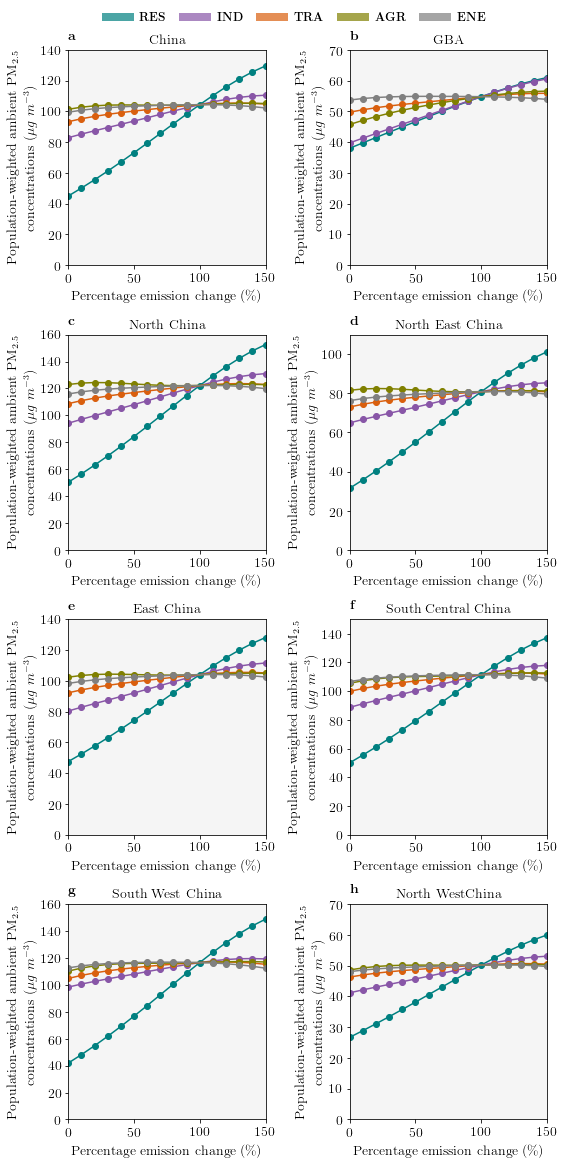

In [78]:
fig = plt.figure(1, figsize=(8, 16))
gs = gridspec.GridSpec(4, 2)

label = 'Population-weighted ambient PM$_{2.5}$\nconcentrations (${\\mu}g$ $m^{-3}$)'
#label = 'Population-weighted ambient O$_{3}$ concentrations\n($ppb$)'

make_plot(0, output, [item for item in popweighted.items() if 'china_' + output in item[0]], label, 'China')
make_plot(1, output, [item for item in popweighted.items() if 'gba_' + output in item[0]], label, 'GBA')
make_plot(2, output, [item for item in popweighted.items() if 'china_north_' + output in item[0]], label, 'North China')
make_plot(3, output, [item for item in popweighted.items() if 'china_north_east_' + output in item[0]], label, 'North East China')
make_plot(4, output, [item for item in popweighted.items() if 'china_east_' + output in item[0]], label, 'East China')
make_plot(5, output, [item for item in popweighted.items() if 'china_south_central_' + output in item[0]], label, 'South Central China')
make_plot(6, output, [item for item in popweighted.items() if 'china_south_west_' + output in item[0]], label, 'South West China')
make_plot(7, output, [item for item in popweighted.items() if 'china_north_west_' + output in item[0]], label, 'North WestChina')

leg_1 = matplotlib.lines.Line2D([], [], color='teal', linewidth=8.0, label=r'\textbf{RES}', alpha=0.7)
leg_2 = matplotlib.lines.Line2D([], [], color='#8856a7', linewidth=8.0, label=r'\textbf{IND}', alpha=0.7)
leg_3 = matplotlib.lines.Line2D([], [], color='#d95f0e', linewidth=8.0, label=r'\textbf{TRA}', alpha=0.7)
leg_4 = matplotlib.lines.Line2D([], [], color='olive', linewidth=8.0, label=r'\textbf{AGR}', alpha=0.7)
leg_5 = matplotlib.lines.Line2D([], [], color='grey', linewidth=8.0, label=r'\textbf{ENE}', alpha=0.7)

gs.tight_layout(fig, rect=[0, 0, 1.0, 1.0])

bb = (fig.subplotpars.left + 0.06, fig.subplotpars.top + 0.03, fig.subplotpars.right - fig.subplotpars.left - 0.1, 0.1)
plt.legend(
    fontsize=12, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=5, frameon=False,
    handles=[leg_1, leg_2, leg_3, leg_4, leg_5], mode='expand', borderaxespad=0., 
    bbox_transform=fig.transFigure
)

plt.savefig('/nfs/a336/earlacoa/png/paper_aia_emulator/' + output + '_line-plot_all.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig('/nfs/a336/earlacoa/png/paper_aia_emulator/' + output + '_line-plot_all.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [85]:
for region in regions.keys():
    print(region, popweighted[region + '_PM2_5_DRY_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0'])

china 104.37547471507506
gba 54.78529331801578
china_north 122.1909820358688
china_north_east 80.84487586184332
china_east 104.07205038806337
china_south_central 111.46020667140158
china_south_west 116.61667860455995
china_north_west 50.20979321457486


### 2D contour plots
data created on arc4 using `emulator_prediction.bash`
then also regridded to population grid using `custom_outputs_regrid.bash`
then grouped by region using `popweighted_region.bash`

In [256]:
pm25_popweighted_china_east = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_east_PM2_5_DRY.joblib')
pm25_popweighted_china_south_central = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_south_central_PM2_5_DRY.joblib')

In [139]:
pm25_popweighted_china = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_PM2_5_DRY.joblib')
pm25_popweighted_gba = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_gba_PM2_5_DRY.joblib')
pm25_popweighted_china_north = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_north_PM2_5_DRY.joblib')
pm25_popweighted_china_north_east = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_north_east_PM2_5_DRY.joblib')
pm25_popweighted_china_east = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_east_PM2_5_DRY.joblib')
pm25_popweighted_china_south_central = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_south_central_PM2_5_DRY.joblib')
#pm25_popweighted_china_south_west = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_south_west_PM2_5_DRY.joblib')
#pm25_popweighted_china_north_west = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_north_west_PM2_5_DRY.joblib')

In [ ]:
o3_popweighted_china = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_o3.joblib')
o3_popweighted_gba = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_gba_o3.joblib')
o3_popweighted_china_north = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_north_o3.joblib')
o3_popweighted_china_north_east = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_north_east_o3.joblib')
o3_popweighted_china_east = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_east_o3.joblib')
o3_popweighted_china_south_central = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_south_central_o3.joblib')
o3_popweighted_china_south_west = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_south_west_o3.joblib')
o3_popweighted_china_north_west = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/popweighted/popweighted_china_north_west_o3.joblib')

In [221]:
def make_plot(index, levels, x, y, z, x_label, y_label):
    ax = fig.add_subplot(gs[index])
    plt.xlim([0, 1.5])
    plt.ylim([0, 1.5])
    plt.xticks(np.arange(0, 1.75, 0.25))
    plt.yticks(np.arange(0, 1.75, 0.25))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Emission scaling, ' + x_label, fontsize=14)
    plt.ylabel('Emission scaling, ' + y_label, fontsize=14)
    norm = matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1])
    cmap = 'viridis'
    im = ax.contourf(x.reshape(16, 16), y.reshape(16, 16), z.reshape(16, 16), levels, cmap=cmap, norm=norm)
    plt.annotate(r'\textbf{' + chr(97 + index) + '}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)

In [197]:
def extract_values(popweighted_values, fixed1, fixed2, fixed3):
    sublist = [item for item in popweighted_values if item != None if fixed1 in item[0] and fixed2 in item[0] and fixed3 in item[0]]
    z = np.array([item[1] for item in sublist])
    inputs_without_fixed = [re.sub(fixed1, '', re.sub(fixed2, '', re.sub(fixed3, '', item[0]))) for item in sublist]
    inputs = [np.array(re.findall(r'\d+\.\d+', item)).astype(float) for item in inputs_without_fixed]
    x = np.array([loc[0] for loc in inputs])
    y = np.array([loc[1] for loc in inputs])
    return x, y, z

In [257]:
outputs = ['pm25']#, 'o3']
#regions = ['china', 'gba']#, 'china_north', 'china_north_east', 'china_east', 'china_south_central', 'china_south_west', 'china_north_west']
regions = ['china_east', 'china_south_central']
predictions = {
#    'china_pm25': pm25_popweighted_china,
#    'china_o3': o3_popweighted_china,
#    'gba_pm25': pm25_popweighted_gba,
#    'gba_o3': o3_popweighted_gba,
#    'china_north_pm25': pm25_popweighted_china_north,
#    'china_north_o3': o3_popweighted_china_north,
#    'china_north_east_pm25': pm25_popweighted_china_north_east,
#    'china_north_east_o3': o3_popweighted_china_north_east,
    'china_east_pm25': pm25_popweighted_china_east,
#    'china_east_o3': o3_popweighted_china_east,
    'china_south_central_pm25': pm25_popweighted_china_south_central,
#    'china_south_central_o3': o3_popweighted_china_south_central,
#    'china_south_west_pm25': pm25_popweighted_china_south_west,
#    'china_south_west_o3': o3_popweighted_china_south_west,
#    'china_north_west_pm25': pm25_popweighted_china_north_west,
#    'china_north_west_o3': o3_popweighted_china_north_west,
}
labels = {
    'pm25': 'population-weighted ambient PM$_{2.5}$ concentrations\n(${\\mu}g$ $m^{-3}$)',
#    'o3': 'population-weighted ambient O$_{3}$ concentrations\n($ppb$)'
}
region_labels = {
#    'china': 'China',
#    'gba': 'GBA',
#    'china_north': 'North China',
#    'china_north_east': 'North East China',
    'china_east': 'East China',
    'china_south_central': 'South Central China',
#    'china_south_west': 'South West China',
#    'china_north_west': 'North West China'
}

<ipython-input-258-5313cfbf5df5>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, rect=[0, 0, 0.9, 0.9])


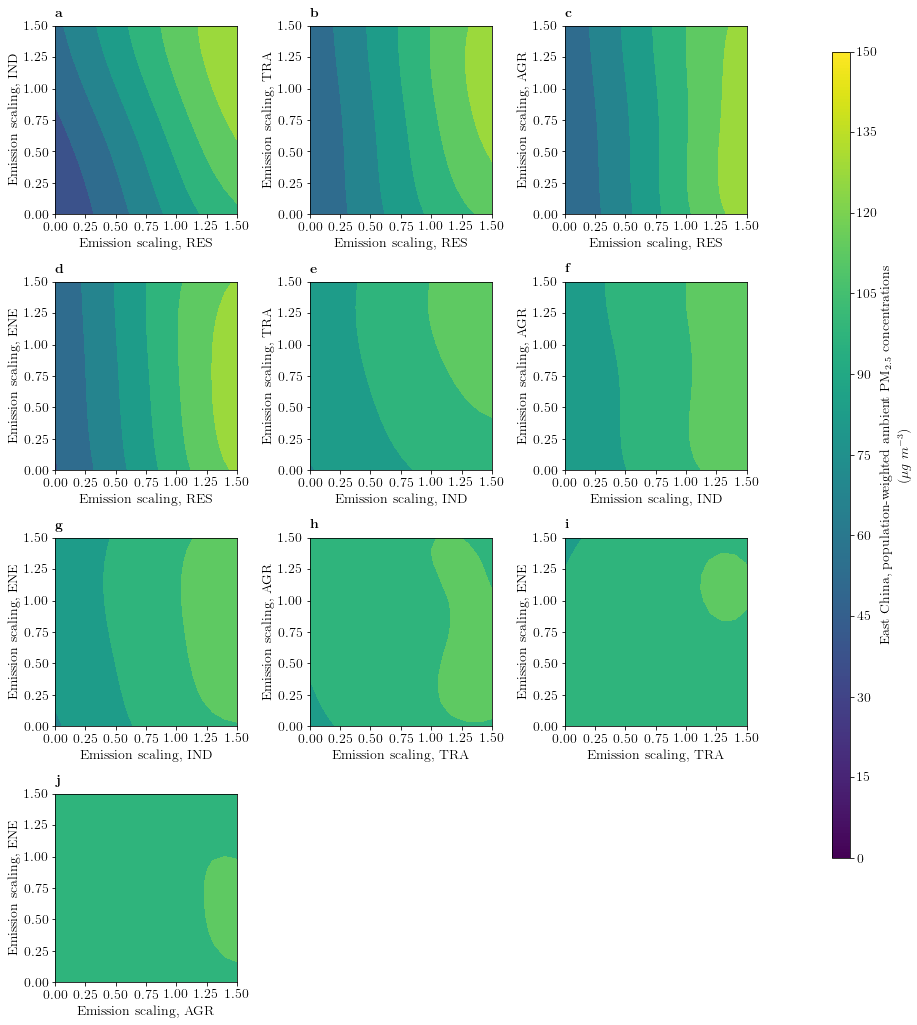

<ipython-input-258-5313cfbf5df5>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, rect=[0, 0, 0.9, 0.9])


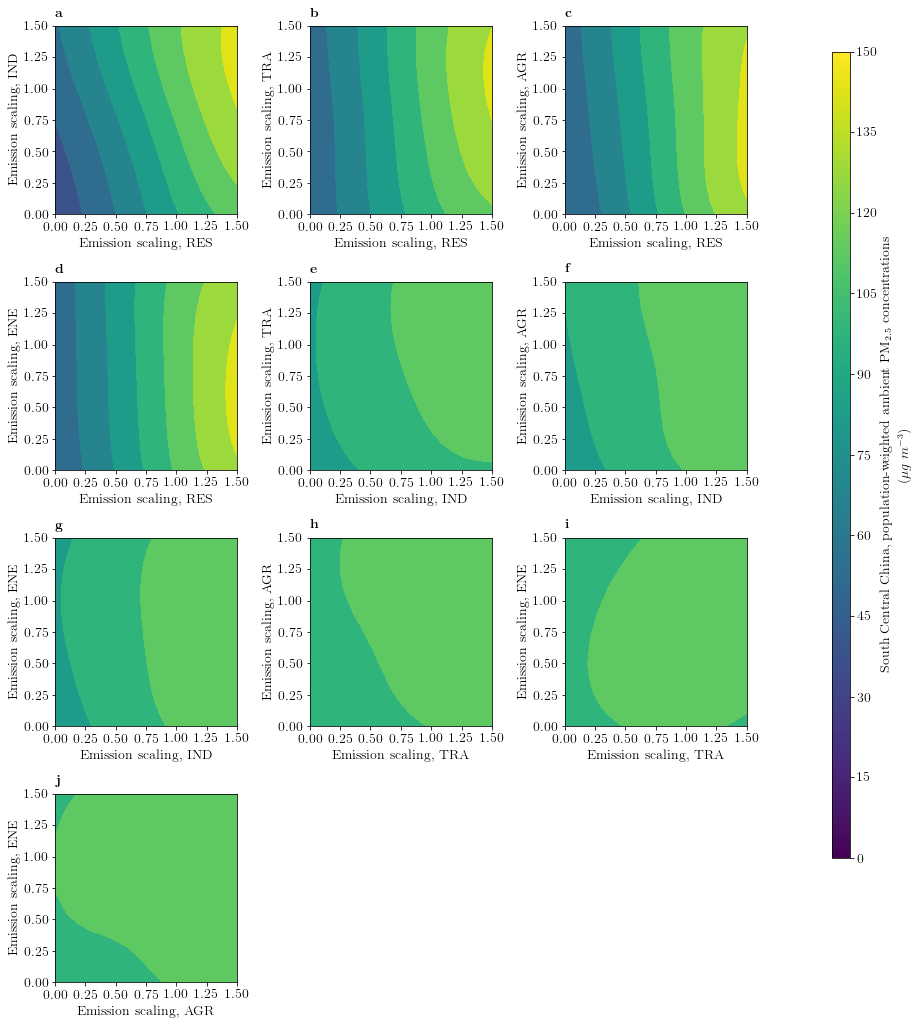

In [258]:
for output in outputs:
    for region in regions:
        label = region_labels[region] + ', ' + labels[output]
        popweighted_values = predictions[region + '_' + output].copy()

        # plot
        fig = plt.figure(1, figsize=(12, 16))
        gs = gridspec.GridSpec(4, 3)

        x_labels = ['RES', 'RES', 'RES', 'RES', 'IND', 'IND', 'IND', 'TRA', 'TRA', 'AGR']
        y_labels = ['IND', 'TRA', 'AGR', 'ENE', 'TRA', 'AGR', 'ENE', 'AGR', 'ENE', 'ENE']
        values = [item[1] for item in popweighted_values if item != None]
        levels = np.linspace(0, round(np.nanmax(values), -1) + 10, 11)

        for index in range(10):
            fixed_inputs = [item for item in 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0'.split('_') if x_labels[index] not in item and y_labels[index] not in item]
            x, y, z = extract_values(popweighted_values, fixed_inputs[0], fixed_inputs[1], fixed_inputs[2])
            make_plot(index, levels, x, y, z, x_labels[index], y_labels[index])


        ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.7])
        sm = plt.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(
                vmin=levels[0], vmax=levels[-1]
            ),
            cmap='viridis'
        )
        sm.set_array([])  
        cb = plt.colorbar(
            sm, 
            cax=ax_cbar, 
            norm=matplotlib.colors.Normalize(
                vmin=levels[0], vmax=levels[-1]
            ),              
            cmap='viridis', 
            ticks=levels
        )
        cb.set_label(label, size=14)
        cb.ax.tick_params(labelsize=14)

        gs.tight_layout(fig, rect=[0, 0, 0.9, 0.9])
        plt.savefig('/nfs/a336/earlacoa/png/paper_aia_emulator/' + output + '_' + region + '_2d-popweight-contour.png', dpi=700, alpha=True, bbox_inches='tight')
        plt.savefig('/nfs/a336/earlacoa/png/paper_aia_emulator/' + output + '_' + region + '_2d-popweight-contour.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
        plt.show()

In [259]:
for region_output, values in predictions.items():
    filenames = [item[0] for item in values if item != None if item[1] != 0.0]
    outputs = [item[1] for item in values if item != None if item[1] != 0.0]
    min_index = outputs.index(min(outputs))
    print(region_output)
    print(filenames[min_index])
    print(outputs[min_index])
    print()

china_east_pm25
ds_RES0.0_IND0.0_TRA0.2_AGR0.7_ENE0.0_PM2_5_DRY_popgrid.nc
22.85465993993792

china_south_central_pm25
ds_RES0.0_IND0.0_TRA0.1_AGR0.5_ENE0.0_PM2_5_DRY_popgrid.nc
25.917033935267614

